## Introduction to Jupyter Notebooks

Welcome to the Jupyter Hub! Jupyter Notebooks provide an interactive environment where you can mix text, equations, programming code, and visual outputs. Here’s a quick guide on how to use it:

### Cells

A notebook is made up of cells. Each cell can contain text or code. There are two main types of cells:

- **Markdown cells**: These contain formatted text written in Markdown and can include images, links, and embedded HTML. This cell is a Markdown cell. You can double-click on it to see the source code. After editing, you can run the cell to render the text.
- **Code cells**: These contain code to be executed by the kernel (the notebook's computational engine). In this notebook, you'll be using Python code cells.

### Running Cells

To run a cell:

1. Click on the cell to select it.
2. Press `Shift + Enter` to execute the cell content. Alternatively, you can use the "Run" button in the toolbar.

Sometimes you'll need to restart. To do this, click on the "Kernel" menu and select "Restart Kernel and Clear All Outputs".

### Editing Cells

To edit any cell, double-click on it. If it’s a code cell, you can start typing your code directly. For markdown cells, after double-clicking, you'll see the Markdown text. You can make changes and run the cell to see the updated format.

### Saving Your Work

You can save your work by clicking on the floppy disk icon in the toolbar or by pressing `Ctrl + S` on your keyboard. For mac users, press `Cmd + S`.

### Adding and Deleting Cells

You can add new cells by clicking the "+" icon on the toolbar. To delete a cell, select it and click the scissors icon, or press `D` twice on your keyboard when in command mode (press `Esc` to enter command mode).

### Getting Help

For help with any Python function, type the function name followed by a question mark `?` and run the cell (e.g., `print?`).

### That's it!

---


### Tutorial

In this tutorial I will show you how to use the code for the Bucket Model. Sometimes you will see `FutureWarning` messages. You can ignore these messages.

### Importing Libraries

First you need to import the code for the Bucket Model. You can do this by running the cell below. Click `Shift + Enter` to run the cell. The green tick mark indicates that the cell has been run.


In [1]:
from bucket_model import BucketModel  # This where the Bucket Model is defined
from bucket_model_optimizer import (
    BucketModelOptimizer,
)  # This class allows you to calibrate the model parameters and evaluate the model performance
from data_processing import (
    preprocess_data,
    train_validate_split,
)  # This class allows you to preprocess the data and split it into training and validation sets

from bucket_model_plotter import (
    plot_water_balance,  # This script contains functions to plot the results of the model
    plot_Q_Q,
    plot_ECDF,
    plot_boxplots,
    plot_monthly_boxplot,
    plot_timeseries,
    plot_parameter_kde,
)

import pandas as pd  # This is a library for data manipulation.

import warnings  # This is a library to handle warnings

warnings.filterwarnings("ignore")  # This is to ignore warnings

### Setting up

In the next cell you need to set the path to the data file, the path to the output file and the catchment area. You can do this by editing the cell below and running it.


In [2]:
CATCHMENT = "LATTERBACH_METEO_NEW"

path_to_file = "data/LATTERBACH_METEO_FULL.txt"
catchment_area = 561.7  # km^2

# WEEK 1: Develop a daily water balance model

### Getting the data

In the next cell you will pre-process the data. This will store the data into a pandas dataframe. A pandas dataframe is like an Excel spreadsheet; it is a 2-dimensional table where you can organize, manipulate, and analyze data easily. You need to provide the catchment area for the transformation of the units from m^3/s to mm/day.


In [3]:
data = preprocess_data(
    path_to_file=path_to_file, catchment_area=catchment_area, filter_dates=(1986, 1999)
)  # This is to preprocess the data

# Let's have a look at the data
data

,day,P_mix,T_max,T_min,Q
date,,,,,
1986-01-01,1,6.4,-0.2,-10.8,1.070579
1986-01-02,2,2.5,1.1,-6.1,0.950600
1986-01-03,3,8.0,0.1,-6.0,0.993669
1986-01-04,4,0.8,-3.2,-12.1,1.098266
1986-01-05,5,1.2,-1.3,-12.7,0.830621
...,...,...,...,...,...
1999-12-27,361,23.4,1.2,-6.8,5.029874
1999-12-28,362,32.4,-1.9,-6.7,4.122343
1999-12-29,363,7.6,-6.0,-8.5,3.307103


### Initialize the model and set the catchment properties.


In [4]:
# Initialize the BucketModel with initial parameter guesses
bucket = BucketModel(
    k=0.5,  # degree-day snowmelt parameter
    S_max=35,  # max soil water storage
    fr=0.8,  # fraction of impermeable area at soil saturation
    rg=7,  # mean residence time of water in groundwater
    snow_threshold_temp=0,
)  # threshold temperature for snowfall

# Set the catchment properties
bucket.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    basin_mean_elevation=2035,  # m.a.s.l 1638
    hru_mean_elevation=2035,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.9,  # °N
)

### You can also change the initial conditions of the model


In [5]:
bucket.change_initial_conditions(S=10, S_gw=100)

Initial conditions updated successfully.
Current initial conditions: S = 10 mm, S_gw = 100 mm


### Run the model


In [6]:
first_run_results = bucket.run(data=data)

# Let's have a look at them
first_run_results.head()

,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip
date,,,,,,,,,,
1986-01-01,0.063976,0.0,14.285714,6.400000,9.936024,85.714286,0.0,0.000000,6.400000,6.4
1986-01-02,0.079067,0.0,12.244898,8.518056,10.238901,73.469388,0.0,0.381944,2.118056,2.5
1986-01-03,0.079219,0.0,10.495627,16.386908,10.290830,62.973761,0.0,0.131148,7.868852,8.0
1986-01-04,0.056881,0.0,8.996252,17.186908,10.233949,53.977509,0.0,0.000000,0.800000,0.8
1986-01-05,0.059600,0.0,7.711073,18.386908,10.174349,46.266437,0.0,0.000000,1.200000,1.2


### Visualize the results

To save the plots just add the `output_destination` parameter to the `plot` function. For example:

```python
output_destination = 'images/first_wat_bal.png'
plot_water_balance(results=first_run_results, output_destination=output_destination)
```


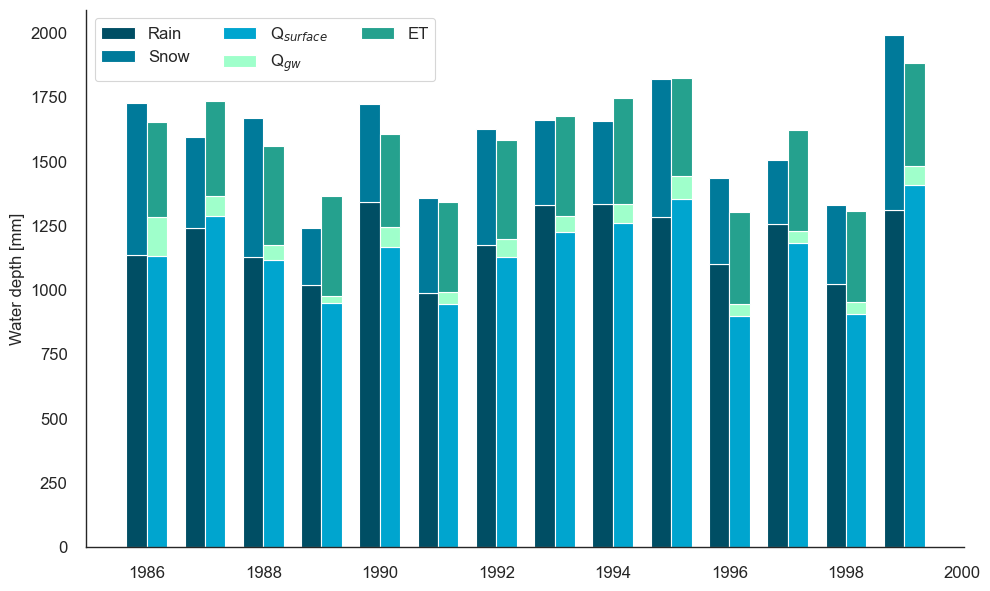

In [7]:
plot_water_balance(results=first_run_results)

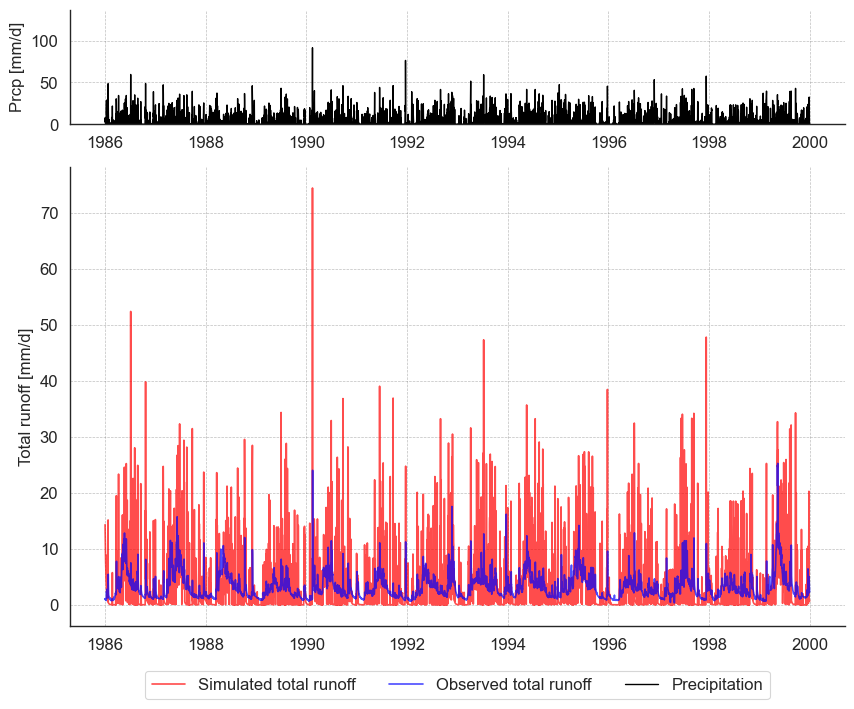

In [8]:
plot_timeseries(
    results=first_run_results,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue", "black"],
    plot_precipitation=True,
)

### Let's look at some stats:


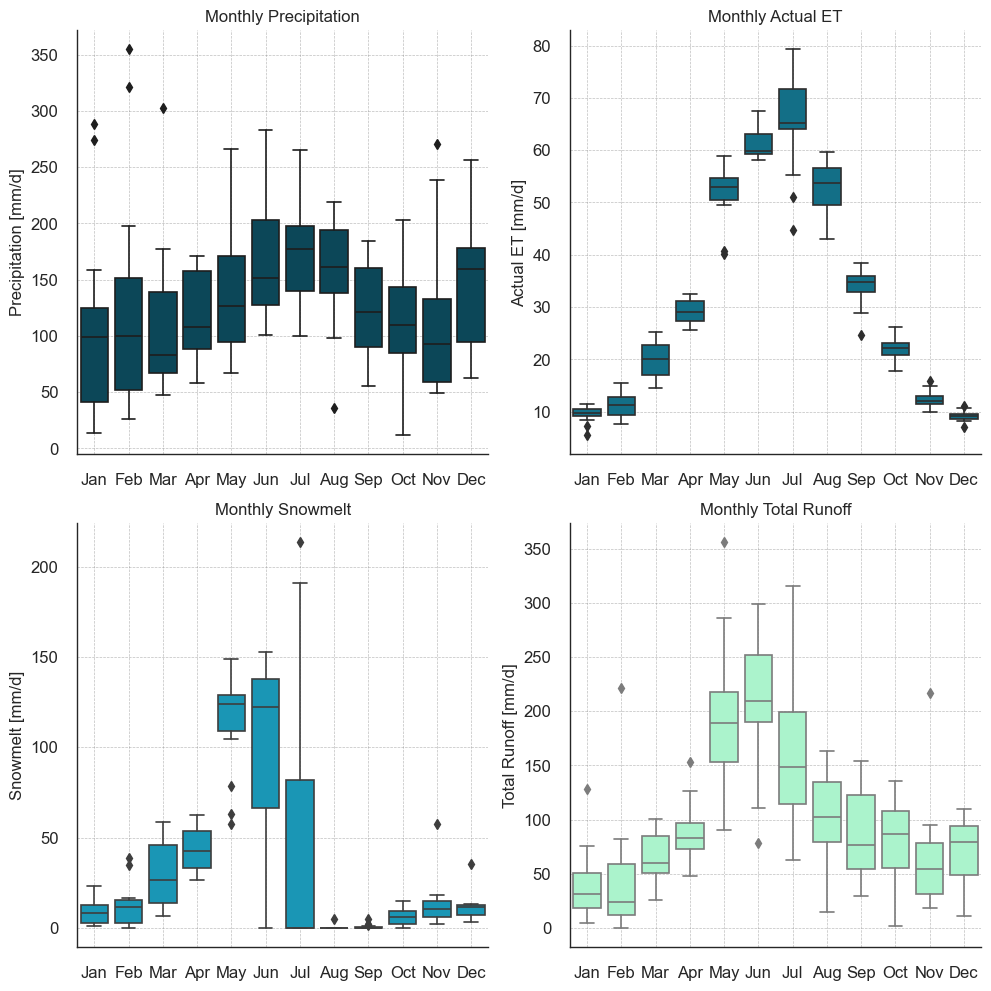

In [9]:
plot_monthly_boxplot(results=first_run_results, figsize=(10, 10))

### Uncomment the following lines to see all other plots:

The plots have some more customization options. You can have a look at the `bucket_model_plotter.py` file to see all the options.


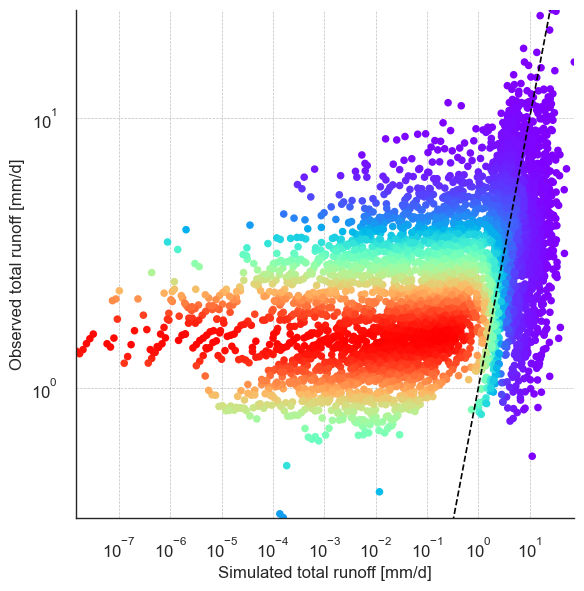

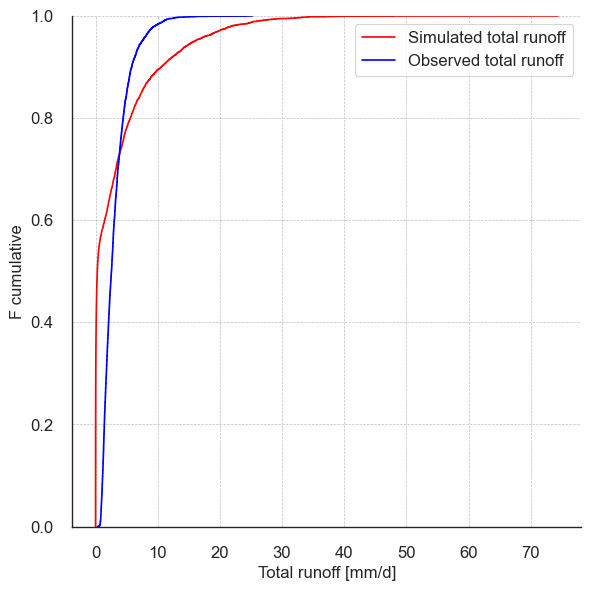

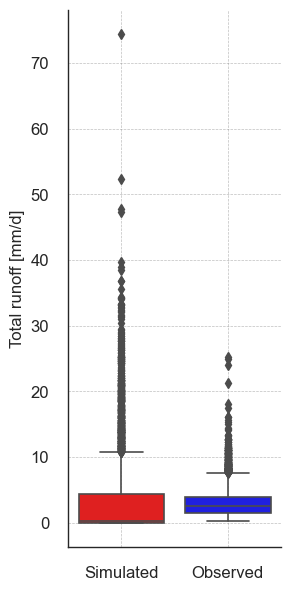

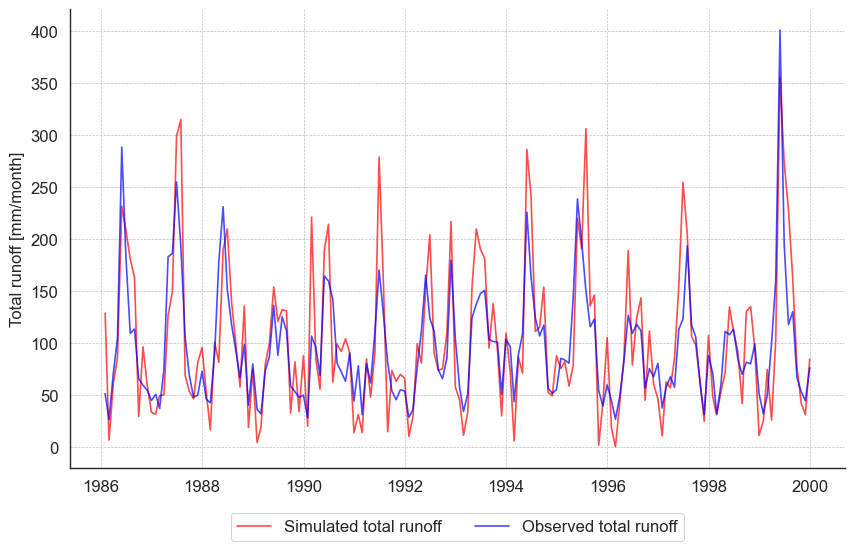

In [10]:
plot_Q_Q(results=first_run_results, observed=data)

plot_ECDF(results=first_run_results, observed=data, palette=["red", "blue"])

plot_boxplots(results=first_run_results, observed=data, palette=["red", "blue"])

plot_timeseries(
    results=first_run_results,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue"],
    monthly=True,
)

### Update the parameters

The first guess is not very impressive. Let's try another guess and see how it goes.


In [11]:
second_guess = {
    "k": 0.6,
    "S_max": 40,
    "fr": 0.2,
    "rg": 14.5,
    "snow_threshold_temp": 2.0,
}

bucket.update_parameters(parameters=second_guess)

In [12]:
# You can check that the parameters have been updated by printing the model:
print(bucket)

BucketModel(k=0.6, S_max=40, fr=0.2, rg=14.5, snow_threshold_temp=2.0)


In [13]:
second_run_results = bucket.run(data=data)

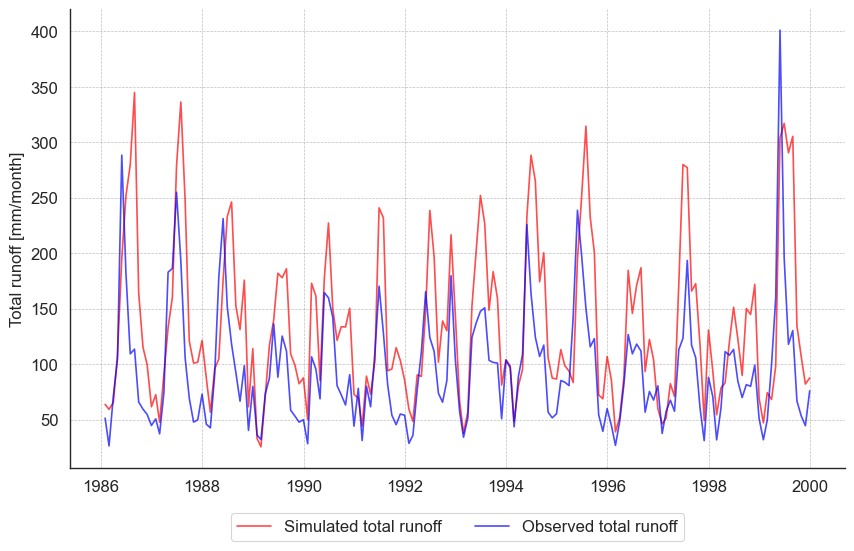

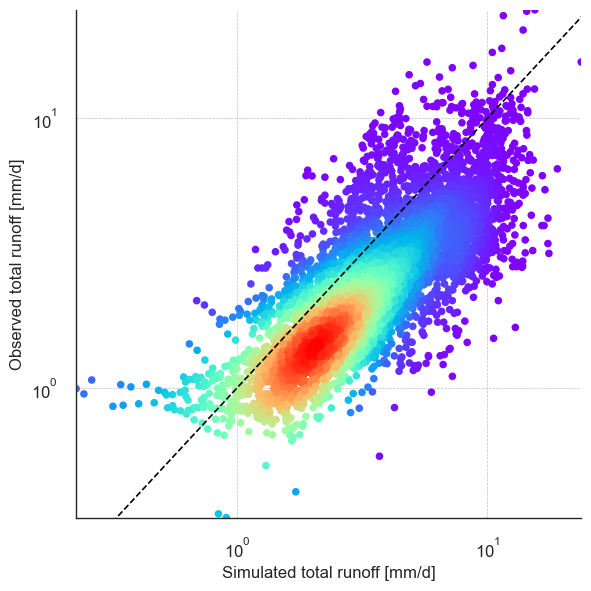

In [14]:
plot_timeseries(
    results=second_run_results,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue"],
    monthly=True,
)
plot_Q_Q(results=second_run_results, observed=data)

### Manually Finding a Good Fit

Iteratively change the model parameters until you find a visually good fit. Invest some time to understand how each parameter influences the results. Here is a step-by-step guide to help you with this process:

1. **Define Your New Guess**

   You can define your new guess just like we did for the second guess:

   ```python
   new_guess = {
      'k': 0.2,
      'S_max': 35,
      'fr': 0.2,
      'rg': 17,
      'snow_threshold_temp': 1
   }
   ```

2. **Update model parameters**

   Update the model parameters with your new guess:

   ```python
   model.update_parameters(new_guess)
   ```

3. **Run the model**

   Run the model with the new parameters:

   ```python
   model.run()
   ```


# WEEK 2: Automatic calibration/validation of the daily water balance model

### Split the data into a training (calibration) and validation set

The `train_size` parameter defines the size of the training set. In the example below we use 80% of the data for training and 20% for validation. Feel free to change that.


In [15]:
train_data, validate_data = train_validate_split(data=data, train_size=0.8)

In [16]:
# Let's have a look at the training data
train_data

,day,P_mix,T_max,T_min,Q
date,,,,,
1986-01-01,1,6.4,-0.2,-10.8,1.070579
1986-01-02,2,2.5,1.1,-6.1,0.950600
1986-01-03,3,8.0,0.1,-6.0,0.993669
1986-01-04,4,0.8,-3.2,-12.1,1.098266
1986-01-05,5,1.2,-1.3,-12.7,0.830621
...,...,...,...,...,...
1997-03-09,68,0.0,9.3,0.1,2.691828
1997-03-10,69,0.0,12.0,0.6,2.507246
1997-03-11,70,0.0,12.5,1.0,2.384191


In [17]:
# Let's have a look at the validation data
validate_data

,day,P_mix,T_max,T_min,Q
date,,,,,
1997-03-14,73,2.5,9.0,-2.1,1.999644
1997-03-15,74,0.1,5.2,-1.8,1.907353
1997-03-16,75,0.0,8.0,-0.3,1.891971
1997-03-17,76,0.0,10.1,-0.7,1.922735
1997-03-18,77,4.4,13.5,-0.1,2.061171
...,...,...,...,...,...
1999-12-27,361,23.4,1.2,-6.8,5.029874
1999-12-28,362,32.4,-1.9,-6.7,4.122343
1999-12-29,363,7.6,-6.0,-8.5,3.307103


### Automatic Calibration of Model Parameters

To automatically calibrate the model parameters, follow these steps:

1. **Initialize a BucketModelOptimizer**

   This is the first step in the calibration process.

2. **Define the Method**

   You need to define the method that will be used for the calibration: `local` or `n-folds`.

3. **Set the Parameter Bounds**

   Define the bounds for the parameters. This will guide the calibration process.

After setting up, you can start the calibration process. When you call the `calibrate` method, a uniform random guess is sampled from the parameter bounds and the optimization begins. Let's start simple with the local optimization method.


In [18]:
# Initialize the BucketModelOptimizer with the BucketModel instance and observed data
optimizer = BucketModelOptimizer(
    model=bucket, training_data=train_data, validation_data=validate_data
)
# Define the method
method = "local"

# Define the parameter bounds
bounds = {
    "k": (0.1, 1),
    "S_max": (10, 50),
    "fr": (0.1, 0.3),
    "rg": (10, 35),
    "snow_threshold_temp": (-1.0, 4.0),
}

# Now set the options
optimizer.set_options(method=method, bounds=bounds)

### Now calibrate, it can take up to a minute


In [19]:
calibrated_parameters, _ = optimizer.calibrate(
    verbose=True
)  # For now don't worry about the second output (_)

Initial guess: [0.431152, 39.842578, 0.142221, 24.921438, 1.903391]
Current parameter values: [ 1.   39.84  0.1  24.92  1.38]
Current parameter values: [ 1.   39.84  0.1  24.92  1.12]
Current parameter values: [ 1.   39.85  0.1  24.91 -1.  ]
Current parameter values: [ 1.   39.84  0.1  24.91 -0.37]
Current parameter values: [ 1.   39.85  0.1  24.91 -0.19]
Current parameter values: [ 1.   39.85  0.1  24.91 -0.26]
Current parameter values: [ 1.   39.85  0.1  24.91 -0.27]
Current parameter values: [ 1.   39.85  0.1  24.91 -0.27]


### Look at the calibrated parameters


In [20]:
print("calibrated_parameters:", calibrated_parameters)

calibrated_parameters: {'k': 0.997, 'S_max': 39.845, 'fr': 0.1, 'rg': 24.91, 'snow_threshold_temp': -0.274}


### Let's look at the model performance

We will score the model by looking at the Nash-Sutcliffe Efficiency (NSE), the Root Mean Squared Error (RMSE) and the Kling-Gupta Efficiency (KGE). In the `metrics.py` file you can find the formulas for these and other metrics.

The `score_model` function will score the model on the training and validation data separately. Does that make sense to you?


In [22]:
model_perfomance = optimizer.score_model(metrics=["NSE", "RMSE", "KGE"])

# Let's have a look at the model performance
print("model performance:", model_perfomance)

model performance: {'training': {'nse': 0.554, 'rmse': 1.409, 'kge': 0.754}, 'validation': {'nse': 0.535, 'rmse': 1.761, 'kge': 0.733}}


### Update the model with the calibrated parameters. The optimizer works with a copy of the model, so you need to synchronize the model with the calibrated parameters.


In [23]:
bucket_calibrated = (
    optimizer.get_optimized_model()
)  # Now your bucket model has the calibrated parameters :)

Changes from working copy applied to the original model.


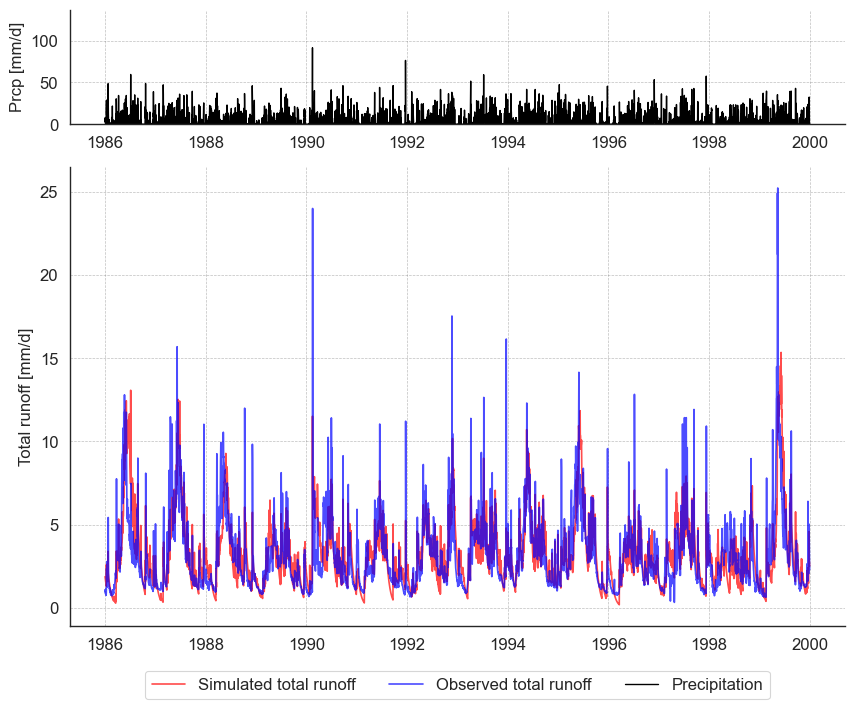

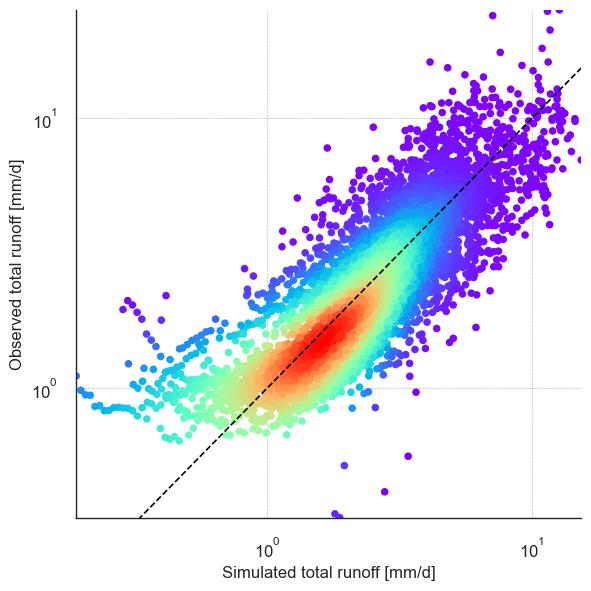

In [24]:
calibrated_results = bucket_calibrated.run(data=data)
plot_timeseries(
    results=calibrated_results,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue", "black"],
    plot_precipitation=True,
    output_destination="images/timeseries_with_precip.png",
)
plot_Q_Q(results=calibrated_results, observed=data)

### N-Fold Calibration

In the N-Fold calibration approach, the model is more robustly calibrated by N sampling initial guesses from the parameter bounds. For each sample, the BucketModelOptimizer finds a local minimum, improving the chances of reaching the 'best possible fit' by exploring different starting points. These parameter sets are stored in a DataFrame.

After performing the N-Fold calibration, the best set of parameters is identified using the `get_best_parameters` method. This method evaluates each parameter set based on the RMSE. You can change the metric in the `bucket_model_optimizer.py` file.

Let's try it out


In [25]:
# Initialize the BucketModelOptimizer with the BucketModel instance and observed data
optimizer = BucketModelOptimizer(
    model=bucket, training_data=train_data, validation_data=validate_data
)
# Define the method
method = "n-folds"

# Define the parameter bounds
bounds = {
    "k": (0.1, 1),
    "S_max": (10, 50),
    "fr": (0.0, 0.3),
    "rg": (5, 35),
    "snow_threshold_temp": (-1.0, 4.0),
}

# Now set the options
optimizer.set_options(
    method=method, bounds=bounds, folds=10
)  # Now you need to define the number of folds

Calibration is going to take a while (circa 10 minutes). Be patient :)


In [26]:
calibrated_parameters, n_folds_results = optimizer.calibrate()

# Let's have a look at the n-folds results
n_folds_results

,k,S_max,fr,rg,snow_threshold_temp
0,0.991,29.828,0.074,16.627,-0.299
1,0.100,26.784,0.076,21.515,0.799
2,0.996,38.002,0.075,19.239,-0.278
3,0.880,35.056,0.075,12.869,-0.401
4,1.000,39.331,0.077,24.107,-0.234
5,0.100,37.413,0.074,15.307,1.921
6,1.000,16.949,0.078,25.009,-0.476
7,0.100,11.116,0.077,31.045,1.600
8,0.100,30.837,0.074,26.443,2.417
9,0.953,24.916,0.074,14.458,-0.351


### Let's look at the parameter distribution


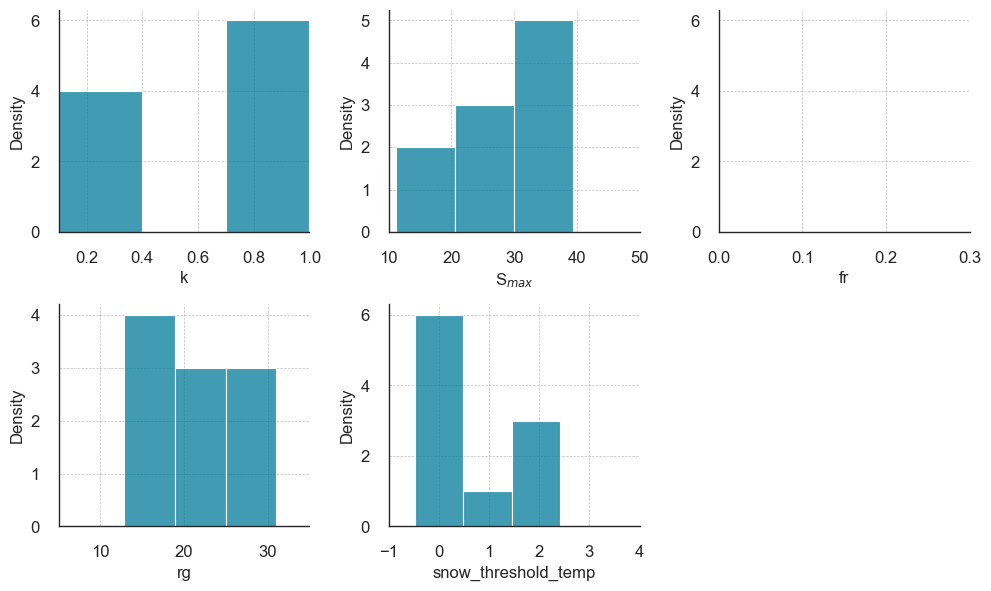

In [27]:
plot_parameter_kde(n_fold_results=n_folds_results, bounds=bounds)

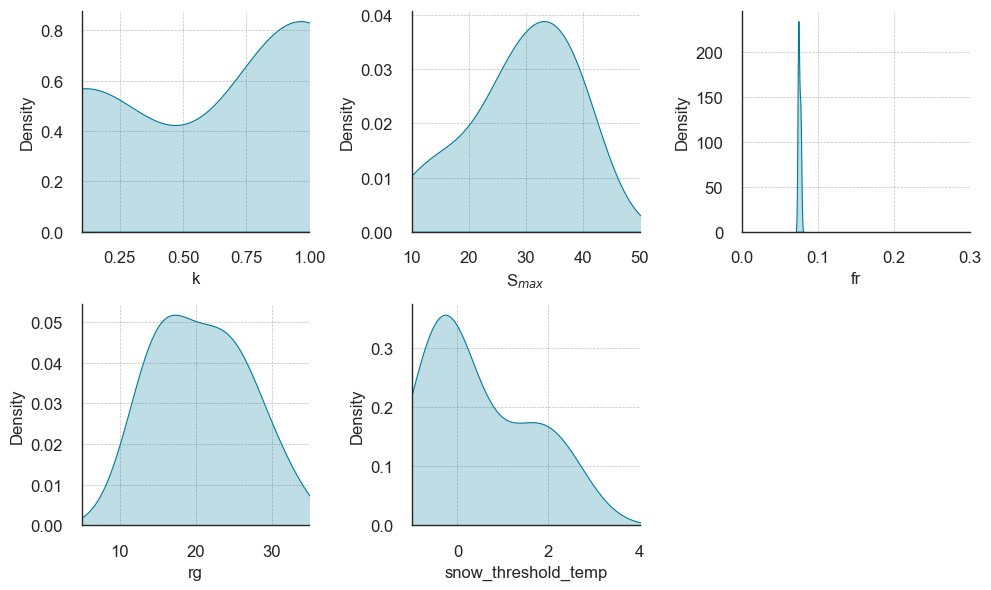

In [28]:
plot_parameter_kde(n_fold_results=n_folds_results, bounds=bounds, plot_type="kdeplot")

Changes from working copy applied to the original model.


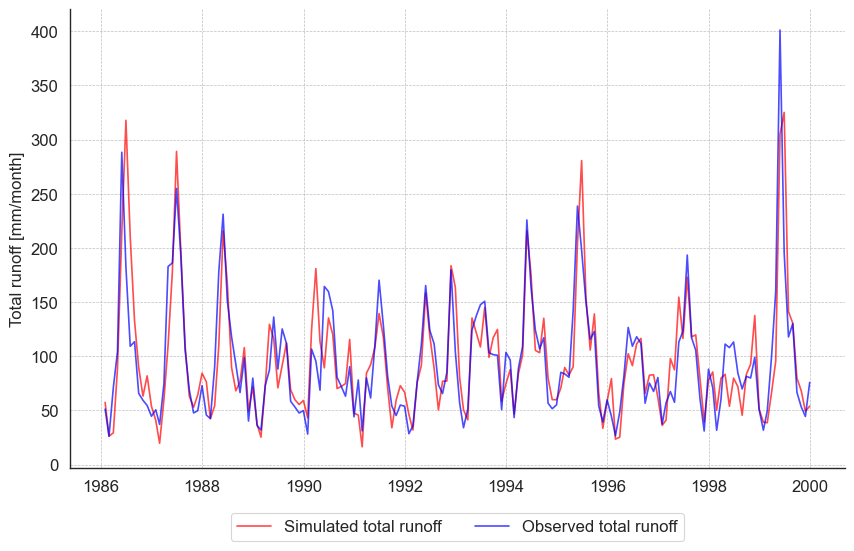

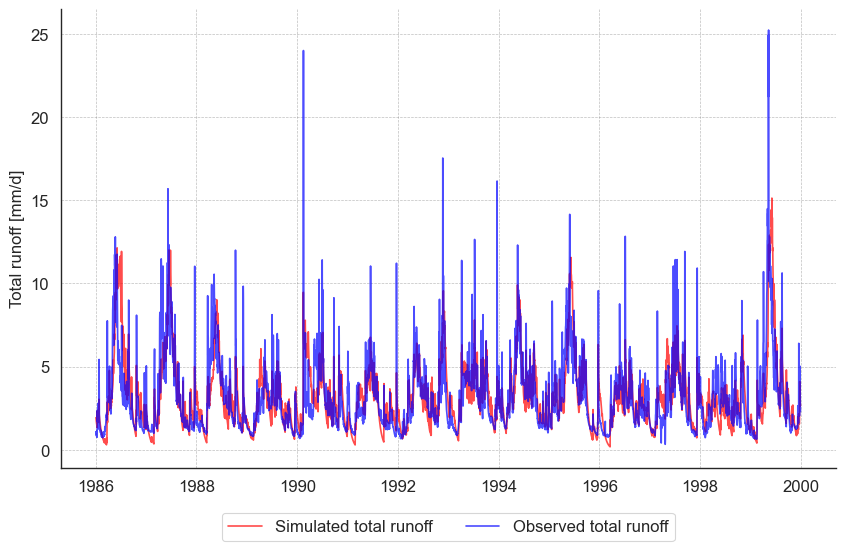

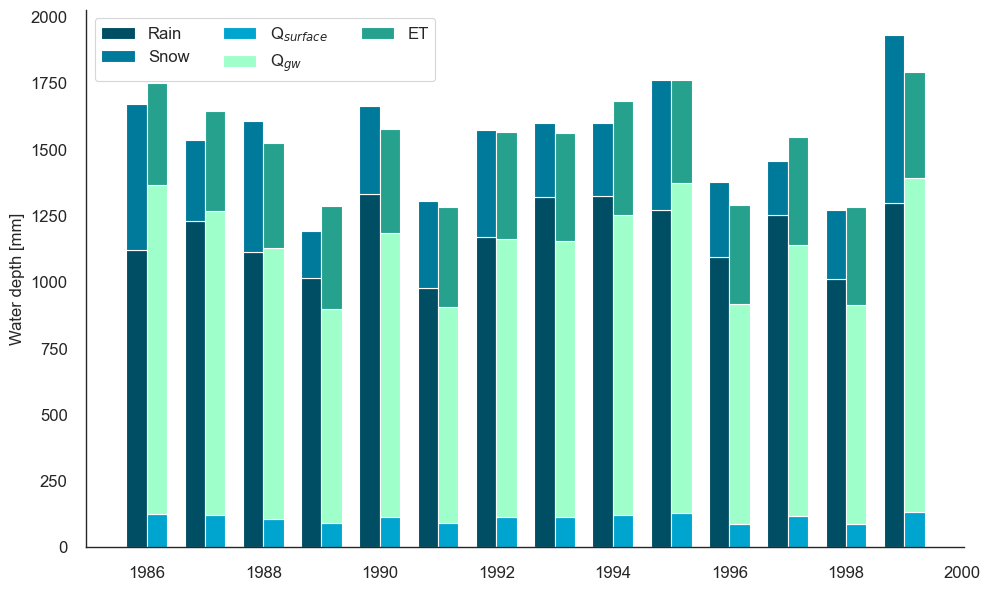

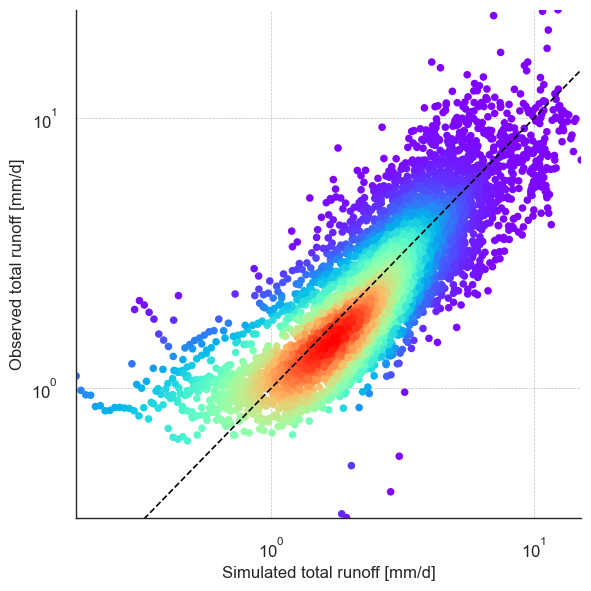

In [29]:
images_folder = "images_new_data"

# Let's sync the models
n_fold_calibrated_model = optimizer.get_optimized_model()

final_run = n_fold_calibrated_model.run(data=data)

plot_timeseries(
    results=final_run,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue"],
    monthly=True,
)
plot_timeseries(
    results=final_run,
    observed=data,
    start_year="1986",
    end_year="2000",
    palette=["red", "blue"],
)
plot_water_balance(results=final_run)
plot_Q_Q(results=final_run, observed=data)

In [30]:
# Let's look at the best parameters:
print(n_fold_calibrated_model)
print(calibrated_parameters)

BucketModel(k=1.0, S_max=39.331, fr=0.077, rg=24.107, snow_threshold_temp=-0.234)
{'k': 1.0, 'S_max': 39.331, 'fr': 0.077, 'rg': 24.107, 'snow_threshold_temp': -0.234}


### Let's look at model performance


In [31]:
calibrated_model_perfromance = optimizer.score_model(metrics=["NSE", "RMSE", "KGE"])
calibrated_model_perfromance

{'training': {'nse': 0.554, 'rmse': 1.409, 'kge': 0.753},
 'validation': {'nse': 0.533, 'rmse': 1.765, 'kge': 0.73}}

### WEEK 3: Local parameter sensitivity

To be discussed


In [ ]:
optimizer.plot_of_surface(
    param1="fr", param2="rg", n_points=10, unit_1="", unit_2="days"
)

In [ ]:
optimizer.plot_of_surface(
    param1="k",
    param2="snow_threshold_temp",
    n_points=10,
    unit_1="mm/°C/day",
    unit_2="°C",
)

In [ ]:
optimizer.local_sensitivity_analysis()